In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [17]:
#read csv file into Pandas DataFrame
df = pd.read_csv('data/diabetic_data.csv')

## Introduction
With estimated costs in the order of tens of billions per annum, hospital readmissions impose a significant financial burden on health care institutions across the nation. Up until more recent times, there was not a lot of incentive for Hospitals to reduce these readmissions. When Center for Medicares and Medicaid Services began public reporting hospital readmission rates, the ethical and professional incentive was there, but hospitals that aimed to reduce readmissions were losing revenue unless they could fill their beds. Enter the Hospital Readmissions Reduction Program (HRRP) circa 2013 which provided financial incentive for Hospitals to reduce readmissions. 

This has still proven to be a difficult task but hospitals are employing a number of strategies to reduce the preventable readmissions. Progress has been made since the implementation of the HRRP but estimates of readmissions that could have been prevented are still as high as 70%. It is therefore in their best interest to find ways to further reduce this undesirable outcome. 

## Strategy

- Data Preprocessing
- Exploratory Data Analysis
- Hypothesis Testing

## Data Overview

The data set was made available by the UCI Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

- It contains 101766 observations with 50 different features. 
- Features are largely categorical variables

## Data Preprocessing

The metric of interest that labels whether a patient was readmitted or not has three possible values: 

- **<30** : Patients that were readmitted in less than thirty days. 
- **>30** : Paitents that were readmitted in greater than thirty days. 
- **NO** : Patients that were not readmitted

The metric of concern according to the HRRP is patients that were readmitted in less than thirty days. Therefore we will rename the column to 'readmitted_<30d' and combine the '>30' and 'NO'.  

In [19]:
df = df.rename(columns={'readmitted':'readmitted_<30d'})

In [22]:
# finding frequency of patients readmitted in less than 30 days. 
df['readmitted_<30d'].replace({'>30': 'False', 'NO': 'False',
                               '<30': 'True'}, inplace=True)
readmitcounts = pd.DataFrame(df.groupby(df['readmitted_<30d']).size())
readmitcounts = readmitcounts.reset_index()
readmitcounts.columns = ['readmitted_<30d', 'frequency']
readmitcounts


,readmitted_<30d,frequency
0,False,90409
1,True,11357


Text(0.5, 1.0, 'Readmitted Counts')

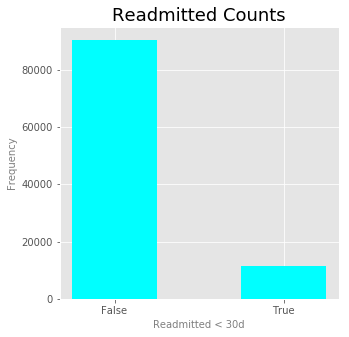

In [115]:
fig,ax = plt.subplots(1, figsize=(5,5))
ax.bar(readmitcounts['readmitted_<30d'], readmitcounts.frequency,
       color='cyan',width=0.5)
ax.set_ylabel('Frequency',fontsize=10,color='grey')
# ax.set_xticks(color='black')
# ax.set_yticks(color='black')
ax.set_xlabel('Readmitted < 30d',fontsize=10,color='grey')
ax.set_title('Readmitted Counts',fontsize=18)


Taking a cursory glance at the data showed that a '?' was used where values were unknown. To address this, we will replace all '?' with np.nan. This will paint a more honest picture of any missing values. 


In [45]:
df = df.replace('?',np.nan)

In [119]:
#iterate through column names and check percentage of data missing/col
#if >= 5% of data missing, list below. 
def missing_data(df,percent):
    '''
    Description: Checks all columns of a df and returns percent of 
    missing data if it is above the defined threshold 'percent' 
    
    Input: df = Pandas DataFrame 
           percent threshold = integer
    Output: String of all columns missing more than the defined 
            threshold % of data. 
    '''
    stringlist = []
    for idx,col in enumerate(df.columns):
        if ((len(df) - df.count()[idx])/len(df) * 100) >= percent:
            stringlist.append(str(("Column '"+str(col)+"' is missing {:2.2f}% of data"
               .format((len(df) - df.count()[idx])/len(df) * 100))))
    return stringlist

missing_data(df,5)

["Column 'weight' is missing 96.77% of data",
 "Column 'payer_code' is missing 37.35% of data",
 "Column 'medical_specialty' is missing 47.91% of data"]

**What do we do with the columns containing missing data?**

- Since weight is missing ~97% of data, we will drop the column. It would have been a nice feature to evaluate. 
- Additionally, payer_code and medical_specialty are missing ~40 and ~50 % of data respectively. Although there are other ways to deal with this, we will remove the columns. 

In [73]:
# flora
# should I drop the other two columns? 

# df.drop(['weight','payer_code','medical_specialty'], axis=1)

Another column that needed cleaning was the **discharge_disposition_id** column. This column along with **admission_type_id** and **admission_source_id** all contained numerical values. These numeric values only served as identifiers and didn't actually have any ordered meaning. The id translations were provided in a separate csv file 'IDs_mapping.csv'.  


In [77]:
dfid = pd.read_csv('data/IDs_mapping.csv')

In [93]:
#split up ID mapping data frame into it's respective columns

admission_type = dfid[0:8]
admission_type.set_index('admission_type_id',inplace=True)

dc_dispo = dfid[9:40]
dc_dispo.columns = ['discharge_disposition_id', 'description']
dc_dispo = dc_dispo.drop(index=9)
dc_dispo = dc_dispo.reset_index()
dc_dispo = dc_dispo.drop('index',axis=1)
dc_dispo.set_index('discharge_disposition_id',inplace=True)

admission_source = dfid[41:]
admission_source.columns = ['admission_source_id','description']
admission_source = admission_source.drop(index=41)
admission_source = admission_source.reset_index()
admission_source = admission_source.drop('index',axis=1)
admission_source.set_index('admission_source_id',inplace=True)

Reviewing these ID data frames, there are some values that will need to be removed from the main df. 
After consideration we will remove records that have a discharge_disposition_id that pertains to a patient 'expiring' (passing away) or a patient that was discharged and transferred to hospice care--reason being that they shouldn't be counted in the group that wasn't readmitted as this would misrepresent that population. 


Based on these criteria, we will remove records where<br> discharge_disposition_id = 11,13,14,18,19,20,21

In [94]:
df = df[~df.discharge_disposition_id.isin([11,13,14,18,19,20,21])]

In [103]:
print('Removing observations with above discharge_disposition_id \
accounted for a {:2.2f}% loss of data'.format((101766-95652)/101766 
                                              * 100))



Removing observations with above discharge_disposition_id accounted for a 6.01% loss of data


In [127]:
#create a data frame with just the patients readmitted in <30 days. 
readmitmask = df['readmitted_<30d'] == 'True'
readmitsdf = df[readmitmask]


## Exploratory Data Analysis

It is worth exploring if any of the numeric variables have any correlations. We will write a function to exract numeric columns from a data frame of choice and return a numeric data frame. This will be performed for both the 

Extraction of numeric columns and plotting in a pairplot did not yield any strong correlations.  ;(

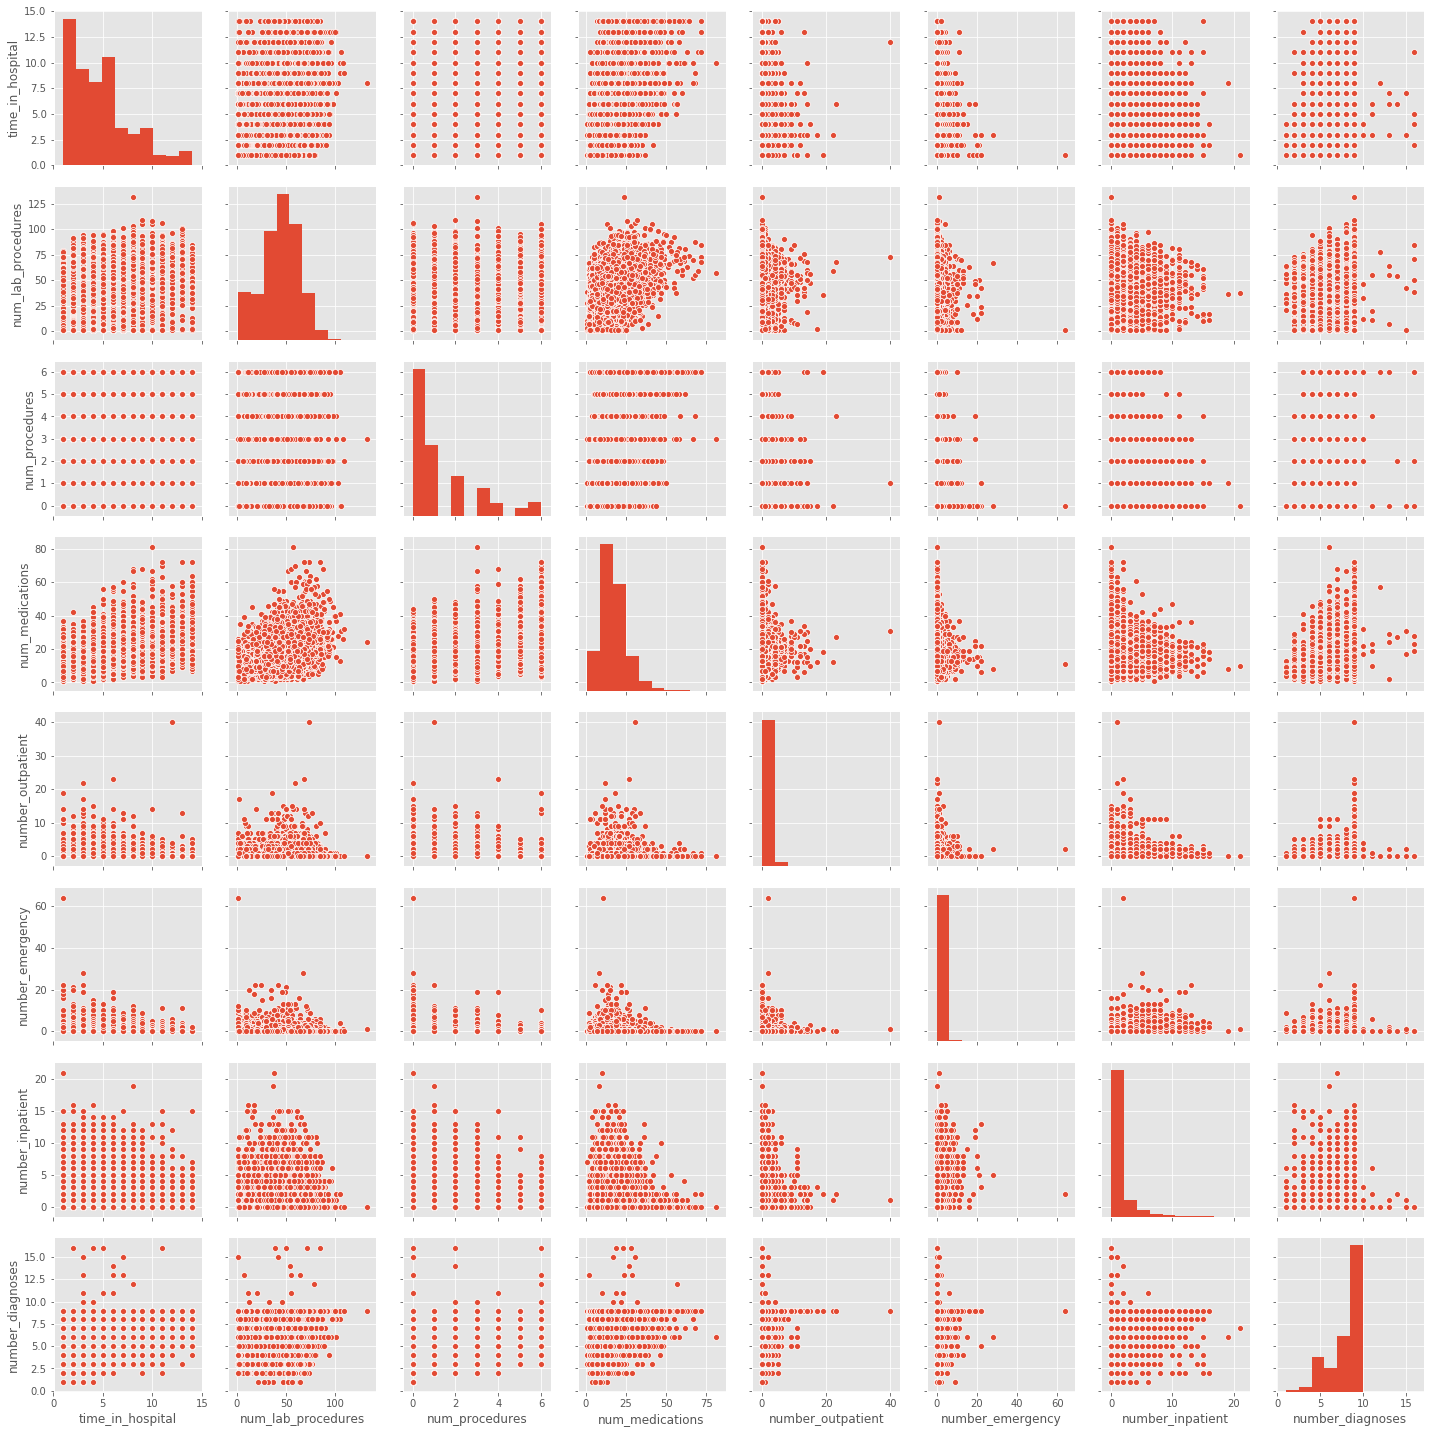

In [133]:
# createa a data frame of continuous variables
def get_num_cols(df):
    '''
    Description: Takes a dataframe as it's input and returns a list
    of all continuous/numeric columns
    Input: Pandas DF
    Output: DF of numeric cols
    '''
    intlist=[]
    for col in df.columns:
        colstring = str(col)
        for val in df[colstring]:
            if type(val) == int:
                intlist.append(colstring)
                break
    return pd.DataFrame(df[intlist])

readmitsnumeric = get_num_cols(readmitsdf).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)
sns.pairplot(readmitsnumeric)


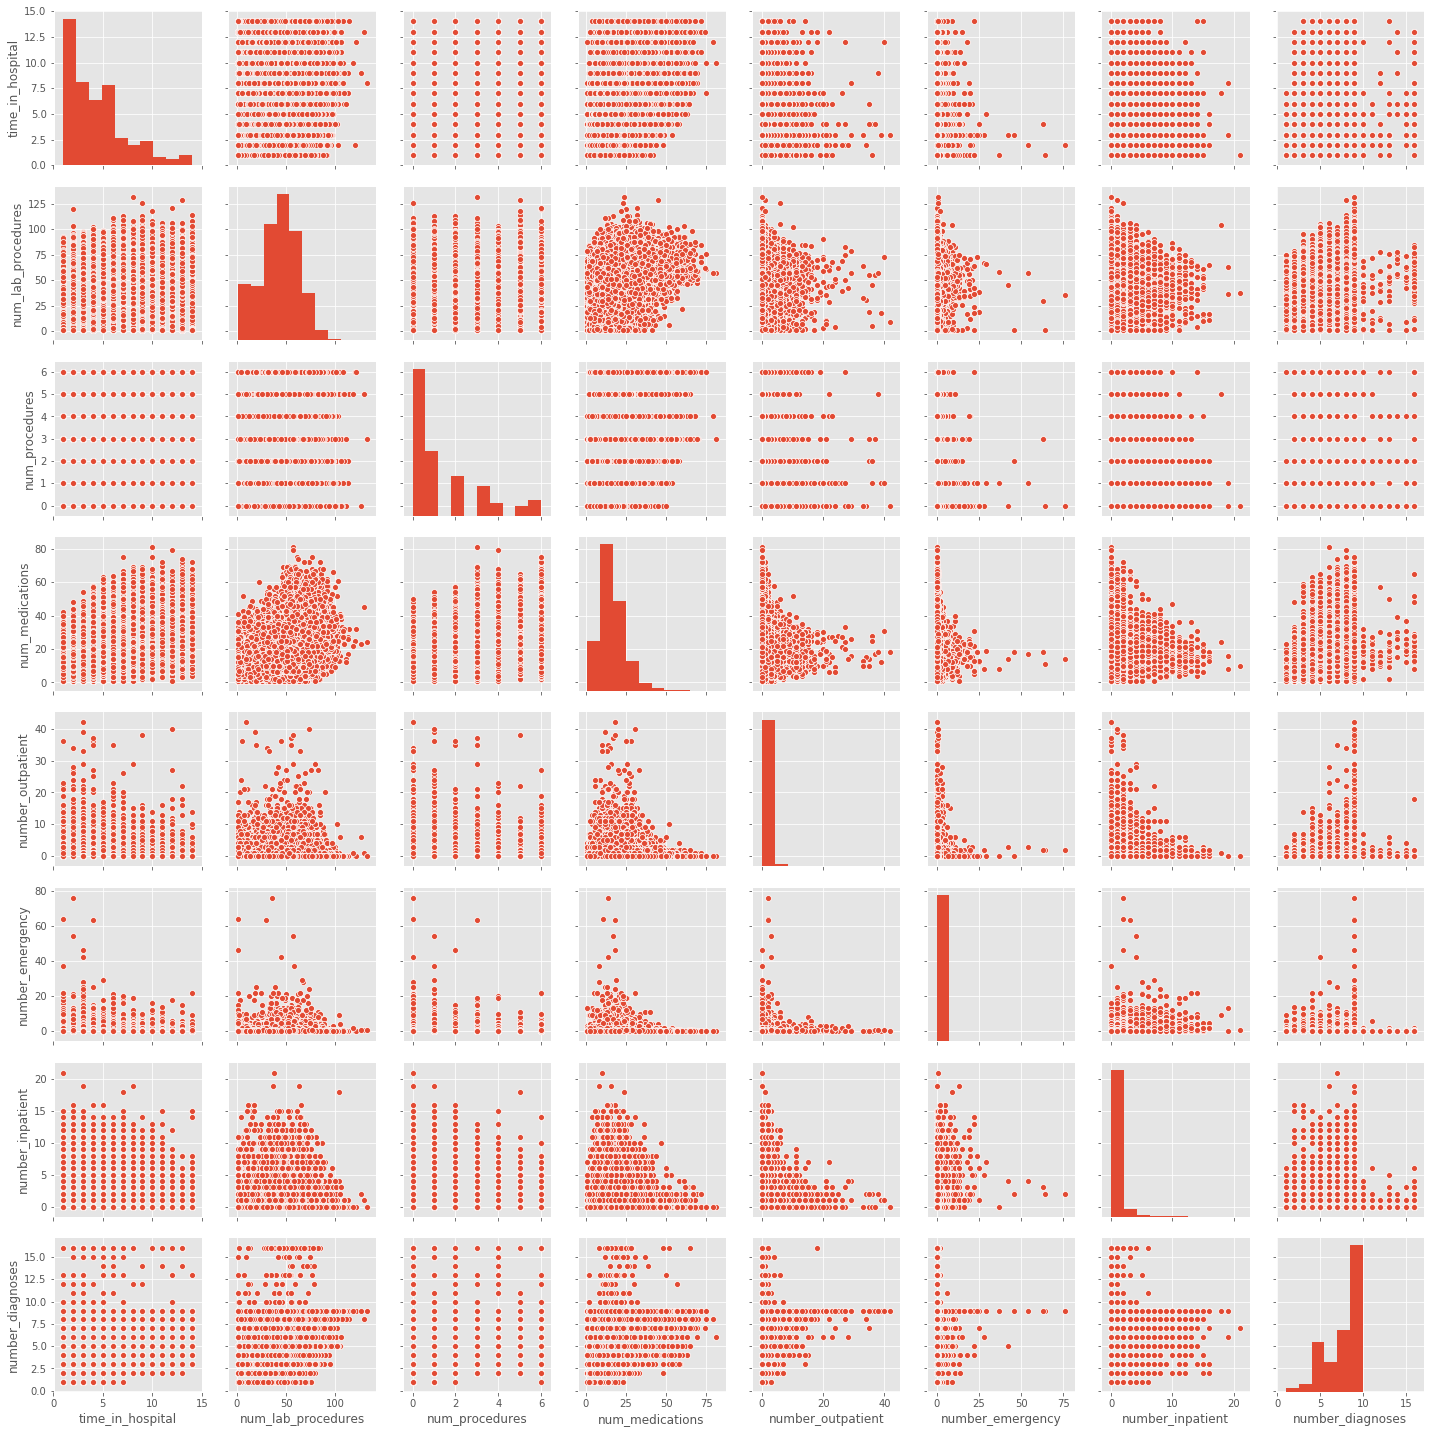

In [135]:
dfnumeric = get_num_cols(df).drop(['encounter_id', 'patient_nbr', 'admission_type_id',
                     'discharge_disposition_id', 'admission_source_id'],axis=1)

sns.pairplot(dfnumeric)
